In [1]:
from array import array
import csv
import itertools
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astroML.density_estimation as aml
import astroML.plotting as amlplot
import iminuit
import pandas as pd
import root_pandas as rpd
import ROOT

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'legend.fontsize': 16})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 

# plt.style.use('presentation')

Welcome to JupyROOT 6.09/01


In [2]:
def getData(inputFiles):
    maxEvents = 500000
    
    columns = []
    columns.append('cluster_pt')
    columns.append('cluster_eta')
    columns.append('cluster_phi')
    columns.append('cluster_e_cross')
    columns.append('cluster_e')
    columns.append('cluster_ncell')
    columns.append('cluster_iso_tpc_04')
    columns.append('cluster_iso_its_04')
    columns.append('cluster_frixione_tpc_04_02')
    columns.append('cluster_frixione_its_04_02')
    columns.append('cluster_nlocal_maxima')
    columns.append('cluster_b5x5_lin')
    columns.append('cluster_b5x5')
    columns.append('cluster_NN1')
    columns.append('cluster_NN2')
    columns.append('cluster_Lambda')
    columns.append('cluster_minMass')
    
    start = time.time()
    dataframe = rpd.read_root(inputFiles, columns=columns, flatten=True, stop=maxEvents)
    end = time.time()
    print 'Processed', ','.join(inputFiles), 'in', end-start, 'seconds'
        
    return dataframe

In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (' , 100*cutDataframe.shape[0]/nbeforecut, '%)'
    return cutDataframe

def applyCuts(fullDataframe):  
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
    ptmin = 12.0
    ptmax = 15.0
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'cluster_pt>10', 'pt >10  GeV :')
    dataframe = applyCut(dataframe, 'cluster_pt<16', 'pt <16 GeV  :')
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05 :')
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')
    dataframe = applyCut(dataframe, 'cluster_NN1>0 and cluster_NN1<1.0', '0<NN1<1.0 :')
    dataframe = applyCut(dataframe, 'cluster_NN2>0 and cluster_NN2<1.0', '0<NN2<1.0 :')
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima<2', 'Local Maxima < 2 :')
    #dataframe = applyCut(dataframe, 'cluster_minMass>0.200', 'pi0 veto :')
    return dataframe

In [4]:

ptmin = 10
ptmax = 16
mcFiles = ['17g6a3_pthat2_clusterv2_small.root']
mcFullHists = getData(mcFiles)
print 'All:', mcFullHists.shape[0]
mc_bkg = applyCuts(mcFullHists)

mcFiles = ['17g6a1_pthat2_clusterv2_small.root']
mcFullHists = getData(mcFiles)
print 'All:', mcFullHists.shape[0]
mc_signal = applyCuts(mcFullHists)


#print 'After All cuts:', mcHists.shape[0]

Processed 17g6a3_pthat2_clusterv2_small.root in 4.54623198509 seconds
All: 134762
pt >10  GeV : 44190  ( 32 %)
pt <16 GeV  : 42640  ( 96 %)
ecross/e > 0.05 : 41608  ( 97 %)
ncell > 2: 41459  ( 99 %)
0<NN1<1.0 : 41459  ( 100 %)
0<NN2<1.0 : 41459  ( 100 %)
Local Maxima < 2 : 41459  ( 100 %)
Processed 17g6a1_pthat2_clusterv2_small.root in 27.4198920727 seconds
All: 994430
pt >10  GeV : 500254  ( 50 %)
pt <16 GeV  : 345456  ( 69 %)
ecross/e > 0.05 : 330955  ( 95 %)
ncell > 2: 328751  ( 99 %)
0<NN1<1.0 : 328751  ( 100 %)
0<NN2<1.0 : 328741  ( 99 %)
Local Maxima < 2 : 328741  ( 100 %)


/root/anaconda2/lib/python2.7/site-packages/root_pandas/readwrite.py:181: FutureWarning:  The option flatten=True is deprecated. Please specify the branches you would like to flatten in a list: flatten=['foo', 'bar']
  "to flatten in a list: flatten=['foo', 'bar']", FutureWarning)


In [7]:
dataFiles = ['13de_clusv2_small.root']#['13f_clusv1_small.root']#['13def_clusv1_small.root']#['13e_clusterv2_small.root']
dataFullHists = getData(dataFiles)
print 'All:',dataFullHists.shape[0]
data = applyCuts(dataFullHists)
print 'After All cuts:', data.shape[0]

Processed 13de_clusv2_small.root in 12.6439418793 seconds
All: 1200019
pt >10  GeV : 234264  ( 19 %)
pt <16 GeV  : 166860  ( 71 %)
ecross/e > 0.05 : 155214  ( 93 %)
ncell > 2: 154920  ( 99 %)
0<NN1<1.0 : 154906  ( 99 %)
0<NN2<1.0 : 154647  ( 99 %)
Local Maxima < 2 : 154647  ( 100 %)
After All cuts: 154647


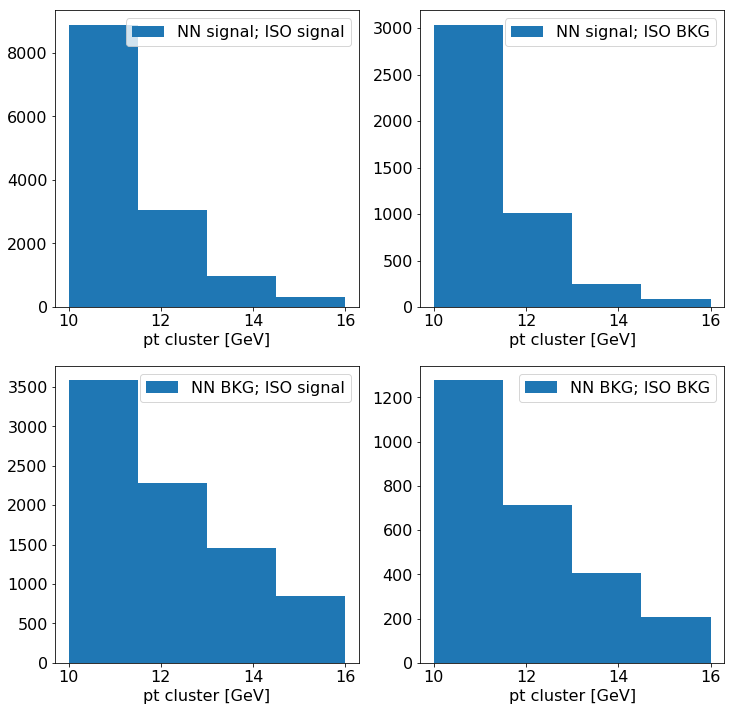

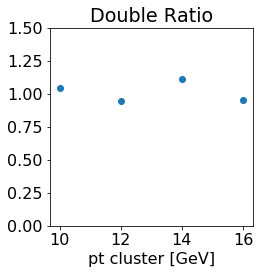

[ 3585.  2277.  1452.   845.] [ 1277.   714.   406.   205.]
[ 2.807361    3.18907563  3.57635468  4.12195122]
[ 1.04258968  0.94720553  1.11504737  0.95244357]


In [16]:
nbins = 4
isoup = 2.0 
noniso_up = 15.0
noniso_do = 4.0 
var = 'cluster_NN1'
varmax = 1.0

NN_signal_do = mc_bkg.cluster_NN1 > 0.55
NN_signal_up = mc_bkg.cluster_NN1 < 0.85
NN_bkg_do    = mc_bkg.cluster_NN1 < 0.55 
ISO_signal_up = mc_bkg.cluster_frixione_tpc_04_02 < 2.0
ISO_bkg_do    = mc_bkg.cluster_frixione_tpc_04_02 > 5.0
ISO_bkg_up    = mc_bkg.cluster_frixione_tpc_04_02 < 15.0     

fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)    
A, x, _ = plt.hist(mc_bkg[NN_signal_do & NN_signal_up & ISO_signal_up]['cluster_pt'], bins=nbins, range=(10.0,16.0),label='NN signal; ISO signal' )
plt.legend()
plt.xlabel('pt cluster [GeV]')
plt.subplot(2,2,2)

B, x, _= plt.hist(mc_bkg[NN_signal_do & NN_signal_up & ISO_bkg_do & ISO_bkg_up]['cluster_pt'], bins=nbins, range=(10.0,16.0),label='NN signal; ISO BKG' )
plt.legend()
plt.xlabel('pt cluster [GeV]')
plt.subplot(2,2,3)

AB = np.divide(A,B)
#print AB
C, x, _ =plt.hist(mc_bkg[NN_bkg_do & ISO_signal_up]['cluster_pt'], bins=nbins, range=(10.0,16.0),label='NN BKG; ISO signal' )
plt.legend()
plt.xlabel('pt cluster [GeV]')
plt.subplot(2,2,4)

D, x, _ = plt.hist(mc_bkg[NN_bkg_do & ISO_bkg_do & ISO_bkg_up]['cluster_pt'], bins=nbins, range=(10.0,16.0),label='NN BKG; ISO BKG' )
plt.legend()
plt.xlabel('pt cluster [GeV]')
#plt.show()

print C, D
CD = np.divide(C,D)
print CD

doubleR = np.divide(AB,CD)
print doubleR
xbins = np.linspace(10.0, 16.0, num=nbins)

fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1) 

#print AB
plt.scatter( xbins,doubleR)
plt.ylim([0.0, 1.5])
plt.xlabel('pt cluster [GeV]')
plt.title('Double Ratio')
plt.show()
#plt.scatter(AB,x)



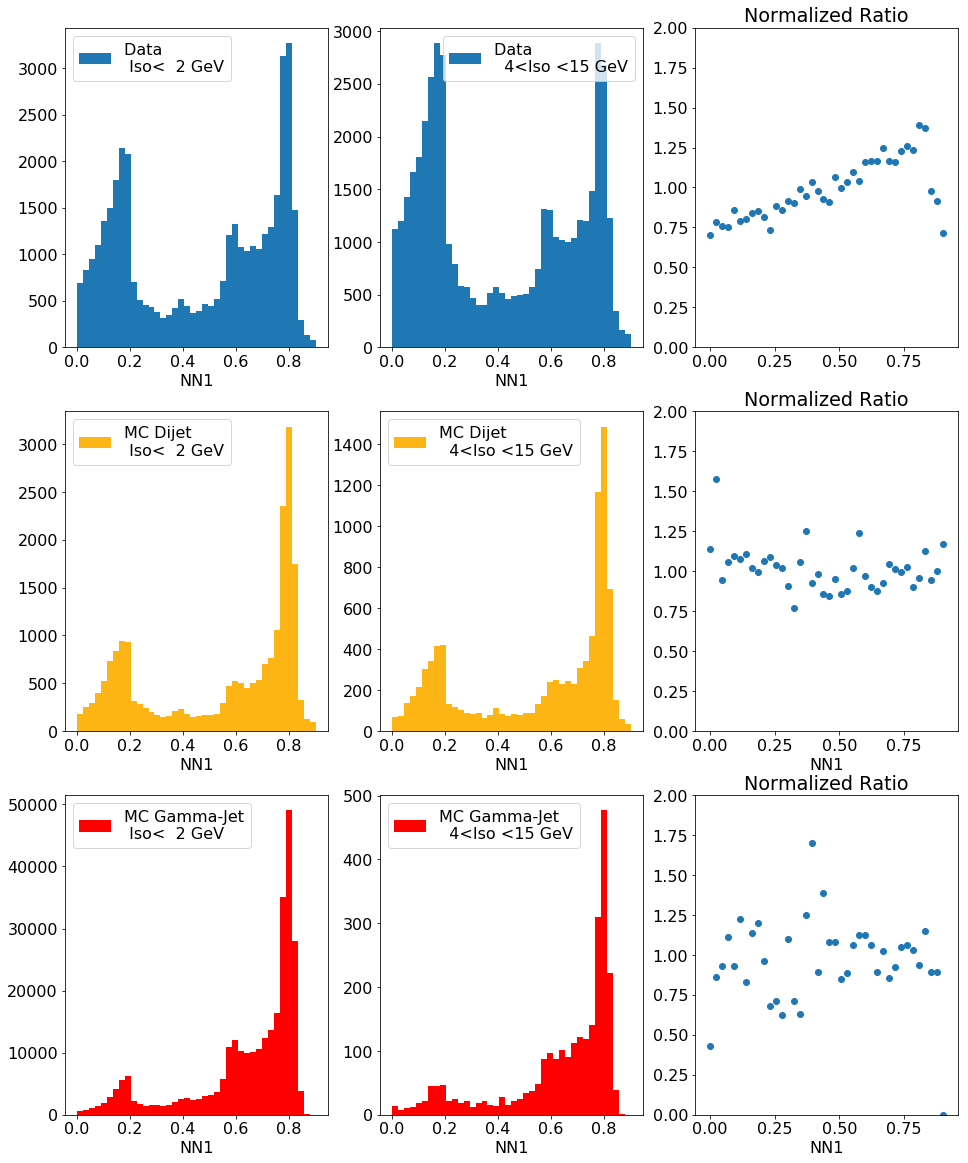

[ 0.70383114  0.78538746  0.7575115   0.75453991  0.85637033  0.79345715
  0.80052984  0.84306461  0.85420728  0.81583273  0.73262101  0.88671684
  0.8599326   0.91287774  0.9058243   0.99064231  0.94556171  1.03642964
  0.9810757   0.92983037  0.91187078  1.06778836  0.99464798  1.03587282
  1.09416616  1.04097033  1.16133821  1.16794956  1.1655935   1.24934161
  1.16840243  1.15663838  1.22596741  1.26014793  1.23655152  1.39095187
  1.37048328  0.97885621  0.91235     0.71823764]
[ 1.13842463  1.57613194  0.94767576  1.05963337  1.09529126  1.07652998
  1.10607016  1.02191269  0.99665445  1.06158006  1.0883621   1.04023266
  1.02257633  0.90630955  0.76820403  1.05818844  1.24883366  0.9270854
  0.98274523  0.85957456  0.84272015  0.95278692  0.8551479   0.87549257
  1.02281106  1.23774517  0.97219139  0.89898604  0.87779516  0.92498982
  1.04397011  1.01092434  0.99589324  1.02371645  0.90229547  0.96020794
  1.12504339  0.9451341   1.00345445  1.16898155]
[ 0.43077937  0.85960948 

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in divide


In [18]:
nbins = 40
isoup = 2.0 
noniso_up = 15.0
noniso_do = 4.0 
maskiso = data.cluster_frixione_tpc_04_02<isoup
masknoniso_do =  data.cluster_frixione_tpc_04_02> noniso_do
masknoniso_up =  data.cluster_frixione_tpc_04_02 <noniso_up

var = 'cluster_NN1'
varmax = 0.90
xbins = np.linspace(0,varmax,nbins)
#var = 'cluster_b5x5_lin'
#varmax = 2.0
#var = 'cluster_Lambda'
#varmax = 2.0

mccolor = '#FDB515'

fig = plt.figure(figsize=(16,20))
plt.subplot(3,3,1)    
A, x, _ = plt.hist(data[maskiso][var], bins=nbins, range=(0.0,varmax),label='Data \n Iso< %2.0f GeV'%isoup)
plt.xlabel('NN1')
plt.legend()
plt.subplot(3,3,2)
B, x, _ = plt.hist(data[masknoniso_up & masknoniso_do][var], bins=nbins, range=(0.0,varmax),label='Data \n %2.0f<Iso <%2.0f GeV' %(noniso_do,noniso_up))
plt.xlabel('NN1')
plt.legend()


plt.subplot(3,3,3)
A = np.array(A, dtype='f')/np.sum(A)
B= np.array(B, dtype='f')/np.sum(B)
ratio = np.divide(A,B)
ratio[np.isnan(ratio)] = 0
ratio[np.isinf(ratio)] = 0
print ratio
xbins = np.linspace(0.0, varmax, num=len(x)-1)
plt.scatter(xbins,ratio)
plt.ylim([0.0, 2.0])
plt.title('Normalized Ratio')
#plt.ylim([0.5, 1.5])




maskiso = mc_bkg.cluster_frixione_tpc_04_02<isoup
masknoniso_do =  mc_bkg.cluster_frixione_tpc_04_02>noniso_do 
masknoniso_up =  mc_bkg.cluster_frixione_tpc_04_02 <noniso_up
plt.subplot(3,3,4)
A, x, _ = plt.hist(mc_bkg[maskiso][var], bins=nbins, range=(0.0,varmax), label='MC Dijet \n Iso< %2.0f GeV'%isoup,color=mccolor)
plt.xlabel('NN1')
plt.legend()
plt.subplot(3,3,5)
B, x, _ = plt.hist(mc_bkg[masknoniso_up & masknoniso_do][var], bins=nbins, range=(0.0,varmax),label='MC Dijet \n %2.0f<Iso <%2.0f GeV' %(noniso_do,noniso_up),color=mccolor)
plt.xlabel('NN1')
plt.legend()

plt.subplot(3,3,6)

A = np.array(A, dtype='f')/np.sum(A)
B= np.array(B, dtype='f')/np.sum(B)

ratio = np.divide(A,B)
ratio[np.isnan(ratio)] = 0
ratio[np.isinf(ratio)] = 0
print ratio
xbins = np.linspace(0.0, varmax, num=len(x)-1)
plt.scatter(xbins,ratio)
plt.xlabel('NN1')
plt.ylim([0.0, 2.0])
plt.title('Normalized Ratio')
#plt.ylim([0.5, 1.5])

maskiso = mc_signal.cluster_frixione_tpc_04_02<2.0
masknoniso_do =  mc_signal.cluster_frixione_tpc_04_02>5 
masknoniso_up =  mc_signal.cluster_frixione_tpc_04_02 <15
plt.subplot(3,3,7)
A, x, _  = plt.hist(mc_signal[maskiso][var], bins=nbins, range=(0.0,varmax),label='MC Gamma-Jet\n Iso< %2.0f GeV'%isoup,color='red')
plt.xlabel('NN1')
plt.legend()
plt.subplot(3,3,8)
B, x, _ = plt.hist(mc_signal[masknoniso_up & masknoniso_do][var], bins=nbins, range=(0.0,varmax),label='MC Gamma-Jet\n %2.0f<Iso <%2.0f GeV' %(noniso_do,noniso_up),color='red')
plt.xlabel('NN1')
plt.legend()

plt.subplot(3,3,9)
A = np.array(A, dtype='f')/np.sum(A)
B= np.array(B, dtype='f')/np.sum(B)

ratio = np.divide(A,B)
ratio[np.isnan(ratio)] = 0
ratio[np.isinf(ratio)] = 0
print ratio
xbins = np.linspace(0.0, varmax, num=len(x)-1)
plt.scatter(xbins,ratio)
plt.xlabel('NN1')
plt.ylim([0.0, 2.0])
plt.title('Normalized Ratio')
#plt.ylim([0.5, 1.5])





plt.show()